In [161]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from config import *

In [162]:
path = r'./input/78_columns_mfcc.xlsx'
data = pd.read_excel(path)
X = data[used_feature_columns].values
y = data['score'].values

In [163]:
# 将数据集划分为训练集、验证集和测试集
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

# 2. 定义模型并进行交叉验证
params = {
    "objective": "reg:squarederror",
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.3,
    "seed": 42,
    # "seed": 3,
}
num_rounds = 200

In [164]:
# 使用交叉验证进行模型选择
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5折交叉验证
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"Training fold {fold}...")
    X_fold_train, y_fold_train = X_train_val[train_idx], y_train_val[train_idx]
    X_fold_val, y_fold_val = X_train_val[val_idx], y_train_val[val_idx]

    dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
    dval = xgb.DMatrix(X_fold_val, label=y_fold_val)

    bst = xgb.train(params, dtrain, num_rounds, evals=[(dval, "val")], verbose_eval=10)
    # print(f"Fold {fold} best score: {bst.best_score}\n")

# 3. 在全量数据上重新训练模型，并在测试集上评估模型表现
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=used_feature_columns)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=used_feature_columns)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=used_feature_columns)
dall = xgb.DMatrix(X, label=y, feature_names=used_feature_columns)

watchlist = [(dtrain, "train"), (dval, "val")]
# bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=10, verbose_eval=10)
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=10, verbose_eval=10)

# 在测试集上评估模型表现
y_pred = bst.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
print(f"Test set MSE: {mse:.4f}")

Training fold 0...
[0]	val-rmse:4.30489
[10]	val-rmse:1.84562
[20]	val-rmse:1.16559
[30]	val-rmse:1.05385
[40]	val-rmse:1.02216
[50]	val-rmse:1.02007
[60]	val-rmse:1.01985
[70]	val-rmse:1.01567
[80]	val-rmse:1.01592
[90]	val-rmse:1.01656
[100]	val-rmse:1.01581
[110]	val-rmse:1.01554
[120]	val-rmse:1.01555
[130]	val-rmse:1.01550
[140]	val-rmse:1.01546
[150]	val-rmse:1.01536
[160]	val-rmse:1.01537
[170]	val-rmse:1.01544
[180]	val-rmse:1.01543
[190]	val-rmse:1.01544
[199]	val-rmse:1.01546
Training fold 1...
[0]	val-rmse:4.06622
[10]	val-rmse:1.62665
[20]	val-rmse:0.98314
[30]	val-rmse:0.90430
[40]	val-rmse:0.90678
[50]	val-rmse:0.90055
[60]	val-rmse:0.90050
[70]	val-rmse:0.89951
[80]	val-rmse:0.89787
[90]	val-rmse:0.89769
[100]	val-rmse:0.89810
[110]	val-rmse:0.89831
[120]	val-rmse:0.89858
[130]	val-rmse:0.89831
[140]	val-rmse:0.89835
[150]	val-rmse:0.89797
[160]	val-rmse:0.89795
[170]	val-rmse:0.89777
[180]	val-rmse:0.89764
[190]	val-rmse:0.89762
[199]	val-rmse:0.89760
Training fold 2...

In [165]:
# 保存模型
bst.save_model("xgboost_model.model")

In [166]:
a = pd.DataFrame()
a['true'] = y_test
a['predict'] = y_pred
a['difference'] = abs(y_pred - y_test)
a

,true,predict,difference
0,6.366667,6.108274,0.258393
1,6.266667,6.110631,0.156035
2,6.233333,5.434375,0.798959
3,7.550000,6.707161,0.842839
4,5.633333,5.059970,0.573363
5,4.266667,5.282751,1.016084
6,5.766667,5.592592,0.174075
7,6.266667,5.429413,0.837253
8,4.368850,5.026950,0.658100
9,5.733333,5.942159,0.208825


In [167]:
from sklearn.metrics import r2_score

r2 = r2_score(a['true'], a['predict'])
print('r2:', r2)

r2: 0.6155008114024463


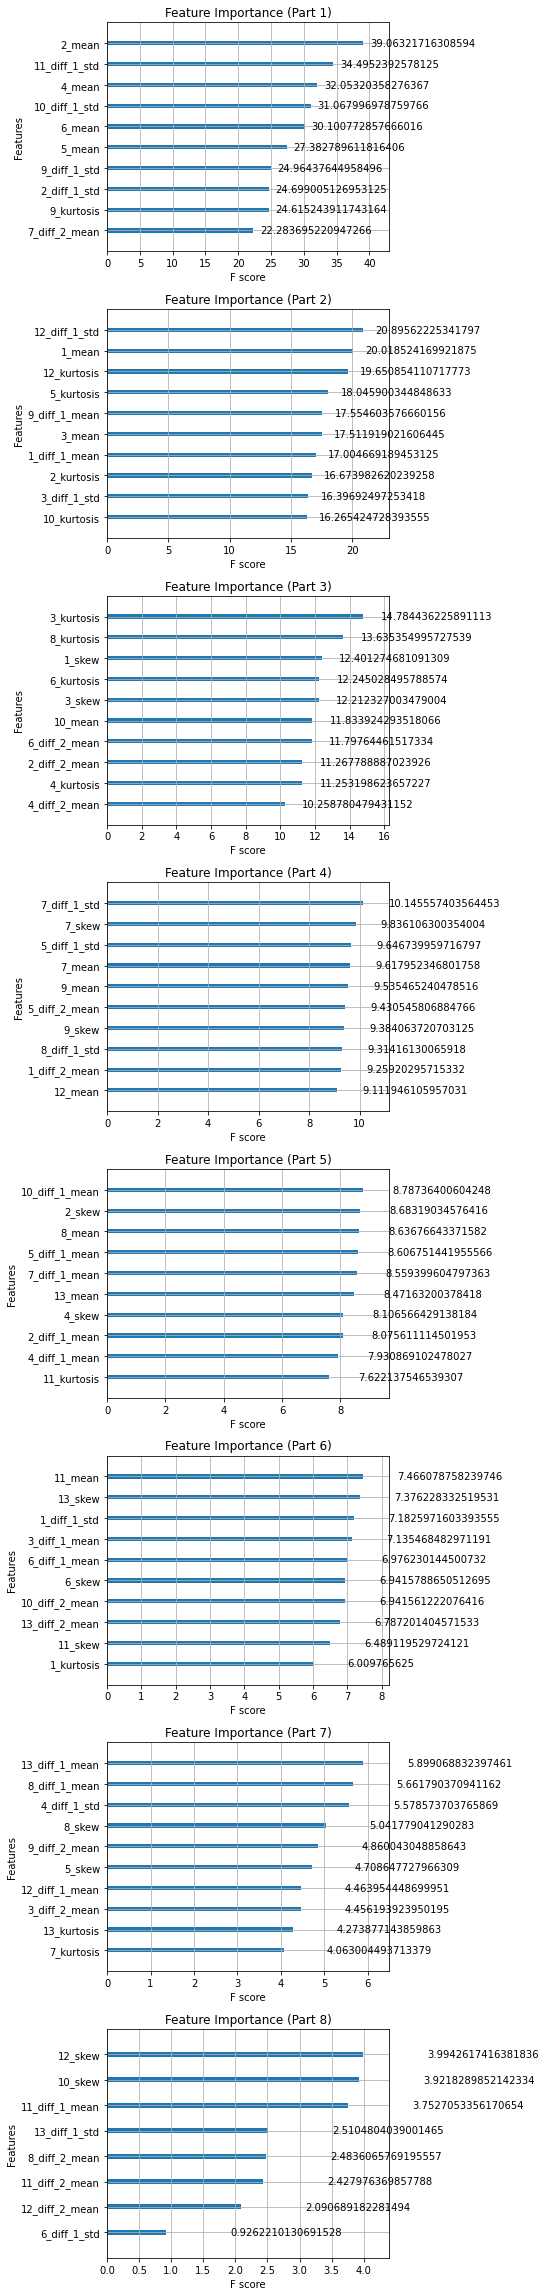

In [169]:
import matplotlib.pyplot as plt

# 获取特征重要性
# importance = bst.get_score(importance_type='weight')
# importance = bst.get_score(importance_type='gain')
# importance = bst.get_score(importance_type='cover')
importance = bst.get_score(importance_type='total_gain')
sorted_imp = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# 每张图显示的特征数量
num_features_per_plot = 10

# 计算需要几张图
num_plots = len(sorted_imp) // num_features_per_plot + 1

# 创建多个子图
fig, axes = plt.subplots(num_plots, figsize=(8, num_plots * 4))

# 绘制每个子图中的特征重要性
for i, ax in enumerate(axes.flat):
    start_idx = i * num_features_per_plot
    end_idx = (i + 1) * num_features_per_plot
    imp_subset = dict(sorted_imp[start_idx:end_idx])
    xgb.plot_importance(imp_subset, ax=ax)
    ax.set_title(f'Feature Importance (Part {i + 1})')

plt.tight_layout()
plt.show()